In [1]:
%matplotlib inline

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import gym
import numpy as np
from collections import namedtuple
import random
from matplotlib import pyplot as pl
from IPython.display import clear_output

In [2]:
env = gym.make('Taxi-v2')
eval_env = gym.make('Taxi-v2')
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

In [3]:
input_size = env.observation_space.n
output_size = env.action_space.n
mem_capacity = 20000
batch = 256
lr = 0.005
double_dqn = False
gamma = 0.99
num_steps = 50000
target_update_freq = 500
learn_start = 10000
eval_freq = 300
eval_episodes = 10
eps_decay = 10000
eps_end = 0.1
hidden_layer = 50
l1_regularization = 0
dropout = 0

In [4]:
class DQN_MLP(nn.Module):
    def __init__(self, in_size, out_size, hidden_size, dropout_prob):
        super().__init__()
        self.lin1 = nn.Linear(in_size, hidden_size)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.lin2 = nn.Linear(hidden_size, out_size)
        self.dropout2 = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.dropout1(F.relu(self.lin1(x)))
        return self.dropout2(self.lin2(x))

def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        weight_shape = list(m.weight.data.size())
        fan_in = np.prod(weight_shape[1:4])
        fan_out = np.prod(weight_shape[2:4]) * weight_shape[0]
        w_bound = np.sqrt(6. / (fan_in + fan_out))
        m.weight.data.uniform_(-w_bound, w_bound)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:
        weight_shape = list(m.weight.data.size())
        fan_in = weight_shape[1]
        fan_out = weight_shape[0]
        w_bound = np.sqrt(6. / (fan_in + fan_out))
        m.weight.data.uniform_(-w_bound, w_bound)
        m.bias.data.fill_(0)

In [5]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def add(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        mem_size = len(self.memory)
        batch = random.sample(self.memory, batch_size)
        batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*batch)
        return batch_state, batch_action, batch_reward, batch_next_state, batch_done

    def __len__(self):
        return len(self.memory)

In [6]:
def restart_network():
    network = DQN_MLP(input_size, output_size, hidden_layer, dropout)
    network.apply(init_weights)
    target_network = DQN_MLP(input_size, output_size, hidden_layer, dropout)
    target_network.load_state_dict(network.state_dict())
    memory = ReplayBuffer(mem_capacity)

    optimizer = optim.Adam(network.parameters(), lr=lr)
    
    return network, target_network, memory, optimizer

In [7]:
results = {}

In [8]:
for dropout in [0, 1e-6, 1e-4, 1e-2, 0.1]:
    results[dropout] = {}
    results[dropout]['average_rewards'] = []
    results[dropout]['avg_rew_steps'] = []
    results[dropout]['losses'] = []
    results[dropout]['losses_steps'] = []

    network, target_network, memory, optimizer = restart_network()
    
    done = True
    for step in range(num_steps):
        if done:
            state_idx = env.reset()
            state = torch.zeros([input_size], dtype=torch.float32)
            state[state_idx] = 1

        action = network(state.unsqueeze(0)).max(1)[1].item()
        eps = max((eps_decay - step + learn_start) / eps_decay, eps_end)
        if random.random() < eps:
            action = env.action_space.sample()

        next_state_idx, reward, done, _ = env.step(action)
        next_state = torch.zeros([input_size], dtype=torch.float32)
        next_state[next_state_idx] = 1
        # Done due to timeout is a non-markovian property. This is an artifact which we would not like to learn from.
        if not (done and reward < 0):
            memory.add(state, action, reward, next_state, not done)
        state = next_state

        if step > learn_start:
            batch_state, batch_action, batch_reward, batch_next_state, not_done_mask = memory.sample(batch)

            batch_state = torch.stack(batch_state)
            batch_next_state = torch.stack(batch_next_state)
            batch_action = torch.tensor(batch_action, dtype=torch.int64).unsqueeze(-1)
            batch_reward = torch.tensor(batch_reward, dtype=torch.float32).unsqueeze(-1)
            not_done_mask = torch.tensor(not_done_mask, dtype=torch.float32).unsqueeze(-1)

            current_Q = network(batch_state).gather(1, batch_action)

            with torch.no_grad():
                if double_dqn:
                    next_state_actions = network(batch_next_state).max(1, keepdim=True)[1]
                    next_Q = target_network(batch_next_state).gather(1, next_state_actions)
                else:
                    next_Q = target_network(batch_next_state).max(1, keepdim=True)[0]
                target_Q = batch_reward + (gamma * next_Q) * not_done_mask


            loss = F.smooth_l1_loss(current_Q, target_Q)
            all_params = torch.cat([x.view(-1) for x in network.parameters()])
            loss += l1_regularization * torch.norm(all_params, 1)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            results[dropout]['losses'].append(loss.item())
            results[dropout]['losses_steps'].append(step)

        if step % target_update_freq == 0:
            target_network.load_state_dict(network.state_dict())

        if step % eval_freq == 0 and step > learn_start:
            network.eval()
            total_reward = 0
            for eval_ep in range(eval_episodes):
                eval_state_idx = eval_env.reset()
                while True:
                    eval_state = torch.zeros([input_size], dtype=torch.float32)
                    eval_state[eval_state_idx] = 1

                    action = network(eval_state.unsqueeze(0)).max(1)[1].item()
                    if random.random() < 0.01:
                        action = random.randrange(output_size)
                    eval_state_idx, reward, done, _ = eval_env.step(action)

                    total_reward += reward
                    if done:
                        break
            network.train()

            average_reward = total_reward * 1.0 / eval_episodes
            results[dropout]['average_rewards'].append(average_reward)
            results[dropout]['avg_rew_steps'].append(step)
            print('Step: ' + str(step) + ' Avg reward: ' + str(average_reward))

Step: 10200 Avg reward: -203.6
Step: 10500 Avg reward: -205.4
Step: 10800 Avg reward: -202.7
Step: 11100 Avg reward: -204.5
Step: 11400 Avg reward: -203.6
Step: 11700 Avg reward: -206.3
Step: 12000 Avg reward: -205.4
Step: 12300 Avg reward: -210.8
Step: 12600 Avg reward: -202.7
Step: 12900 Avg reward: -203.6
Step: 13200 Avg reward: -191.2
Step: 13500 Avg reward: -203.6
Step: 13800 Avg reward: -187.0
Step: 14100 Avg reward: -142.7
Step: 14400 Avg reward: -203.6
Step: 14700 Avg reward: -183.8
Step: 15000 Avg reward: -205.4
Step: 15300 Avg reward: -140.3
Step: 15600 Avg reward: -177.9
Step: 15900 Avg reward: -165.6
Step: 16200 Avg reward: -161.0
Step: 16500 Avg reward: -95.3
Step: 16800 Avg reward: -143.7
Step: 17100 Avg reward: -110.5
Step: 17400 Avg reward: -76.3
Step: 17700 Avg reward: -32.3
Step: 18000 Avg reward: 6.2
Step: 18300 Avg reward: -30.7
Step: 18600 Avg reward: -22.9
Step: 18900 Avg reward: -79.8
Step: 19200 Avg reward: -55.6
Step: 19500 Avg reward: -33.6
Step: 19800 Avg rew

Step: 15600 Avg reward: -162.4
Step: 15900 Avg reward: -166.2
Step: 16200 Avg reward: -119.2
Step: 16500 Avg reward: -188.0
Step: 16800 Avg reward: -179.7
Step: 17100 Avg reward: -202.4
Step: 17400 Avg reward: -161.0
Step: 17700 Avg reward: -119.9
Step: 18000 Avg reward: -118.7
Step: 18300 Avg reward: -97.4
Step: 18600 Avg reward: -165.5
Step: 18900 Avg reward: -183.7
Step: 19200 Avg reward: -79.7
Step: 19500 Avg reward: -97.2
Step: 19800 Avg reward: -102.9
Step: 20100 Avg reward: -55.9
Step: 20400 Avg reward: -103.8
Step: 20700 Avg reward: -56.6
Step: 21000 Avg reward: -76.3
Step: 21300 Avg reward: -78.2
Step: 21600 Avg reward: -99.8
Step: 21900 Avg reward: -53.5
Step: 22200 Avg reward: -81.9
Step: 22500 Avg reward: -56.9
Step: 22800 Avg reward: -77.1
Step: 23100 Avg reward: -76.4
Step: 23400 Avg reward: -57.9
Step: 23700 Avg reward: -83.5
Step: 24000 Avg reward: -58.2
Step: 24300 Avg reward: -78.0
Step: 24600 Avg reward: -35.3
Step: 24900 Avg reward: -121.6
Step: 25200 Avg reward: -1

Step: 18000 Avg reward: -204.5
Step: 18300 Avg reward: -201.8
Step: 18600 Avg reward: -206.3
Step: 18900 Avg reward: -205.4
Step: 19200 Avg reward: -206.3
Step: 19500 Avg reward: -205.4
Step: 19800 Avg reward: -207.2
Step: 20100 Avg reward: -207.2
Step: 20400 Avg reward: -202.7
Step: 20700 Avg reward: -205.4
Step: 21000 Avg reward: -202.7
Step: 21300 Avg reward: -206.3
Step: 21600 Avg reward: -205.4
Step: 21900 Avg reward: -209.0
Step: 22200 Avg reward: -204.5
Step: 22500 Avg reward: -194.1
Step: 22800 Avg reward: -205.4
Step: 23100 Avg reward: -179.7
Step: 23400 Avg reward: -183.2
Step: 23700 Avg reward: -202.7
Step: 24000 Avg reward: -204.5
Step: 24300 Avg reward: -202.7
Step: 24600 Avg reward: -210.8
Step: 24900 Avg reward: -207.2
Step: 25200 Avg reward: -205.4
Step: 25500 Avg reward: -204.5
Step: 25800 Avg reward: -189.7
Step: 26100 Avg reward: -203.6
Step: 26400 Avg reward: -205.4
Step: 26700 Avg reward: -204.5
Step: 27000 Avg reward: -205.4
Step: 27300 Avg reward: -209.9
Step: 27

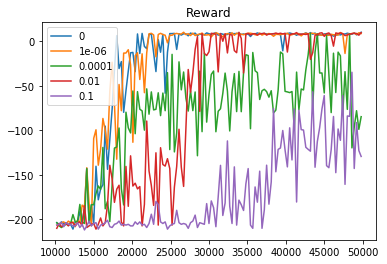

In [9]:
for key in results.keys():
    pl.plot(results[key]['avg_rew_steps'], results[key]['average_rewards'], label=key)

pl.legend()
pl.title('Reward')
pl.show()